<a href="https://colab.research.google.com/github/SaraAsgharQ/Drone-Data-AI-Models-CNN-FNN-XGBoost-/blob/main/AAI_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ae6b0b4abb0b93ee88acecbeb6572a2c107432587a3b8ae67a2406e29bba1c93
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [4]:
!pip install scikit-learn


In [5]:
!pip install --upgrade pip
!pip install tensorflow ml_dtypes
!pip install scikit-learn
!pip install shap xgboost lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [6]:
!pip install scikeras


In [7]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

import xgboost as xgb
import shap
from lime.lime_tabular import LimeTabularExplainer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)



PART 1: DATA PREPROCESSING


Load CSV Files and Combine

In [8]:

dataset_folder = "/content/drive/MyDrive/RawData"
class_folders = ["NormalFlight", "Dos-Drone", "Malfunction-Drone"]

dfs = []
for class_folder in class_folders:
    folder_path = os.path.join(dataset_folder, class_folder)
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    for f in csv_files:
        df_temp = pd.read_csv(f)
        df_temp['Class'] = class_folder  # add target column
        dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)
print("Combined dataset shape:", df.shape)
print(df['Class'].value_counts())


Combined dataset shape: (87417, 80)
Class
NormalFlight         49800
Dos-Drone            19587
Malfunction-Drone    18030
Name: count, dtype: int64


In [9]:
df['Class'].head(10)

,Class
0,NormalFlight
1,NormalFlight
2,NormalFlight
3,NormalFlight
4,NormalFlight
5,NormalFlight
6,NormalFlight
7,NormalFlight
8,NormalFlight
9,NormalFlight


In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87417 entries, 0 to 87416
Data columns (total 80 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   S.No                                           87417 non-null  int64  
 1   setpoint_raw-global_Time                       87417 non-null  float64
 2   setpoint_raw-global_header.seq                 87417 non-null  int64  
 3   setpoint_raw-global_header.stamp.secs          87417 non-null  int64  
 4   setpoint_raw-global_latitude                   87417 non-null  float64
 5   setpoint_raw-global_longitude                  87417 non-null  float64
 6   setpoint_raw-global_altitude                   87417 non-null  float64
 7   battery_Time                                   4349 non-null   float64
 8   battery_header.seq                             4349 non-null   float64
 9   battery_header.stamp.secs                      434

In [11]:
df['Class'] = df['Class'].str.strip()
df['Class'] = df['Class'].str.replace("-", "_")
df['Class'] = df['Class'].str.replace(" ", "_")

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Class_encoded'] = le.fit_transform(df['Class'])
y = df['Class_encoded'].values  # This is what you feed to models


Initial Exploration

In [13]:
print("Columns:", df.columns)
print(df.info())
print(df.describe())


Columns: Index(['S.No', 'setpoint_raw-global_Time', 'setpoint_raw-global_header.seq',
       'setpoint_raw-global_header.stamp.secs', 'setpoint_raw-global_latitude',
       'setpoint_raw-global_longitude', 'setpoint_raw-global_altitude',
       'battery_Time', 'battery_header.seq', 'battery_header.stamp.secs',
       'battery_voltage', 'battery_current', 'battery_temperature',
       'battery_percentage', 'global_position-local_Time',
       'global_position-local_header.seq',
       'global_position-local_header.stamp.secs',
       'global_position-local_pose.pose.position.x',
       'global_position-local_pose.pose.position.y',
       'global_position-local_pose.pose.position.z',
       'global_position-local_pose.pose.orientation.x',
       'global_position-local_pose.pose.orientation.y',
       'global_position-local_pose.pose.orientation.z',
       'global_position-local_twist.twist.linear.x',
       'global_position-local_twist.twist.linear.y',
       'global_position-local_twist

Handle Missing Values

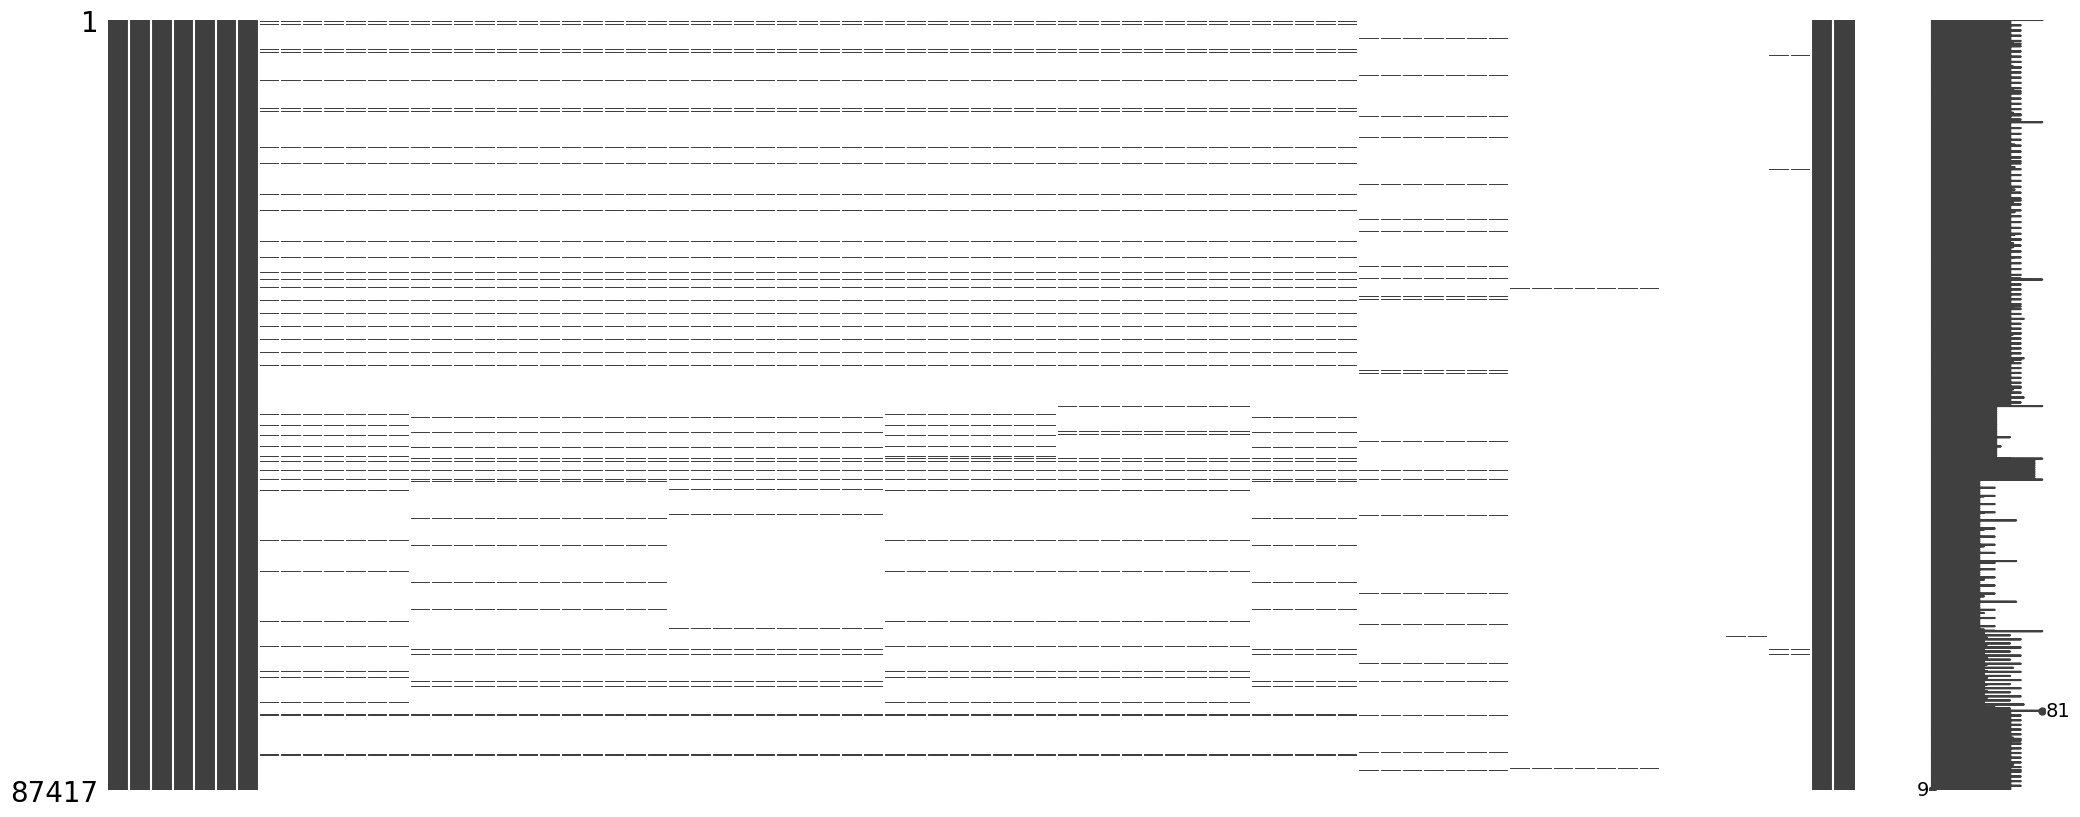

In [14]:
import missingno as msno

# Visualize missing data
msno.matrix(df)
plt.show()

# Simple imputation: fill numeric NaNs with median
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Drop any remaining NaNs (if categorical)
df = df.dropna()


Outlier Detection

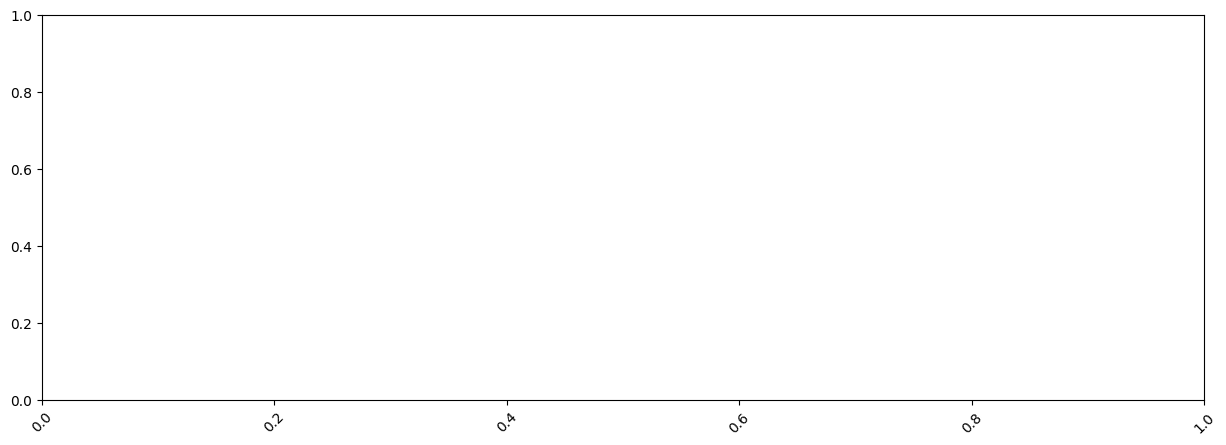

In [15]:
from scipy import stats

# Z-score method
z_scores = np.abs(stats.zscore(df[num_cols]))
df = df[(z_scores < 3).all(axis=1)]

# Boxplots for some key features
plt.figure(figsize=(15,5))
sns.boxplot(data=df[num_cols[:10]])
plt.xticks(rotation=45)
plt.show()


Feature Engineering

In [16]:
# calculate velocity magnitude if x,y,z exist
if all(c in df.columns for c in ['global_position-local_twist.twist.linear.x',
                                 'global_position-local_twist.twist.linear.y',
                                 'global_position-local_twist.twist.linear.z']):
    df['velocity_magnitude'] = np.sqrt(
        df['global_position-local_twist.twist.linear.x']**2 +
        df['global_position-local_twist.twist.linear.y']**2 +
        df['global_position-local_twist.twist.linear.z']**2
    )


In [17]:
numeric_cols = df.select_dtypes(include=np.number).columns
print("Numeric columns:", numeric_cols)

Numeric columns: Index(['S.No', 'setpoint_raw-global_Time', 'setpoint_raw-global_header.seq',
       'setpoint_raw-global_header.stamp.secs', 'setpoint_raw-global_latitude',
       'setpoint_raw-global_longitude', 'setpoint_raw-global_altitude',
       'battery_Time', 'battery_header.seq', 'battery_header.stamp.secs',
       'battery_voltage', 'battery_current', 'battery_temperature',
       'battery_percentage', 'global_position-local_Time',
       'global_position-local_header.seq',
       'global_position-local_header.stamp.secs',
       'global_position-local_pose.pose.position.x',
       'global_position-local_pose.pose.position.y',
       'global_position-local_pose.pose.position.z',
       'global_position-local_pose.pose.orientation.x',
       'global_position-local_pose.pose.orientation.y',
       'global_position-local_pose.pose.orientation.z',
       'global_position-local_twist.twist.linear.x',
       'global_position-local_twist.twist.linear.y',
       'global_position-loc

In [18]:
print(df.shape)


(0, 82)


In [19]:
import os, glob

dataset_folder = "/content/drive/MyDrive/RawData"
class_folders = ["NormalFlight", "Dos-Drone", "Malfunction-Drone"]

for class_folder in class_folders:
    folder_path = os.path.join(dataset_folder, class_folder)
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    print(f"Class '{class_folder}' CSVs found: {len(csv_files)}")
    for f in csv_files[:5]:  # print first 5 files
        print(" ", f)


Class 'NormalFlight' CSVs found: 4
  /content/drive/MyDrive/RawData/NormalFlight/Normal1.csv
  /content/drive/MyDrive/RawData/NormalFlight/Normal2.csv
  /content/drive/MyDrive/RawData/NormalFlight/Normal3.csv
  /content/drive/MyDrive/RawData/NormalFlight/Normal4.csv
Class 'Dos-Drone' CSVs found: 2
  /content/drive/MyDrive/RawData/Dos-Drone/Dos2.csv
  /content/drive/MyDrive/RawData/Dos-Drone/Dos1.csv
Class 'Malfunction-Drone' CSVs found: 2
  /content/drive/MyDrive/RawData/Malfunction-Drone/Malfunction1.csv
  /content/drive/MyDrive/RawData/Malfunction-Drone/Malfunction2.csv


In [20]:
df_temp = pd.read_csv(csv_files[0])
print(df_temp.shape)
print(df_temp.head())


(9040, 79)
   S.No  setpoint_raw-global_Time  setpoint_raw-global_header.seq  \
0     0              1.729406e+09                               1   
1     1              1.729406e+09                               2   
2     2              1.729406e+09                               3   
3     3              1.729406e+09                               4   
4     4              1.729406e+09                               5   

   setpoint_raw-global_header.stamp.secs  setpoint_raw-global_latitude  \
0                                      0                      33.69788   
1                                      0                      33.69788   
2                                      0                      33.69788   
3                                      0                      33.69788   
4                                      0                      33.69788   

   setpoint_raw-global_longitude  setpoint_raw-global_altitude  battery_Time  \
0                      73.016504                 

In [21]:
import os, glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib

# -----------------------------
# 1 Load all CSVs and add target column
# -----------------------------
dataset_folder = "/content/drive/MyDrive/RawData"
class_folders = ["NormalFlight", "Dos-Drone", "Malfunction-Drone"]

dfs = []

for class_folder in class_folders:
    folder_path = os.path.join(dataset_folder, class_folder)
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    print(f"Class '{class_folder}' CSVs found: {len(csv_files)}")
    for f in csv_files:
        df_temp = pd.read_csv(f)
        if df_temp.shape[0] > 0:
            df_temp['Class'] = class_folder  # add target column
            dfs.append(df_temp)

if len(dfs) == 0:
    raise ValueError("No data loaded! Check your CSV files.")

# Combine all data
df = pd.concat(dfs, ignore_index=True)
print("Combined dataset shape:", df.shape)
print(df['Class'].value_counts())

# -----------------------------
# 2 Feature selection
# -----------------------------
# Columns to exclude
exclude_cols = [
    'S.No',
    'Class_encoded',  # target encoding if exists
    '_source_file',   # string column
]

# Exclude time and sequence columns
time_seq_cols = [c for c in df.columns if ('Time' in c) or ('header.seq' in c) or ('header.stamp.secs' in c)]

# Select numeric columns for ML
feature_cols = [c for c in df.select_dtypes(include=np.number).columns
                if c not in exclude_cols + time_seq_cols]

print("Selected feature columns:", feature_cols)
print("Number of features:", len(feature_cols))

X = df[feature_cols]

# -----------------------------
# 3 Handle missing values
# -----------------------------
X = X.fillna(X.mean())

# -----------------------------
# 4 Encode target
# -----------------------------
y = df['Class']
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # NormalFlight->0, Dos-Drone->1, Malfunction-Drone->2

# -----------------------------
# 5 Scale features
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "scaler.joblib")

print("X_scaled shape:", X_scaled.shape)
print("Target classes:", le.classes_)


Class 'NormalFlight' CSVs found: 4
Class 'Dos-Drone' CSVs found: 2
Class 'Malfunction-Drone' CSVs found: 2
Combined dataset shape: (87417, 80)
Class
NormalFlight         49800
Dos-Drone            19587
Malfunction-Drone    18030
Name: count, dtype: int64
Selected feature columns: ['setpoint_raw-global_latitude', 'setpoint_raw-global_longitude', 'setpoint_raw-global_altitude', 'battery_voltage', 'battery_current', 'battery_temperature', 'battery_percentage', 'global_position-local_pose.pose.position.x', 'global_position-local_pose.pose.position.y', 'global_position-local_pose.pose.position.z', 'global_position-local_pose.pose.orientation.x', 'global_position-local_pose.pose.orientation.y', 'global_position-local_pose.pose.orientation.z', 'global_position-local_twist.twist.linear.x', 'global_position-local_twist.twist.linear.y', 'global_position-local_twist.twist.linear.z', 'imu-data_orientation.x', 'imu-data_orientation.y', 'imu-data_orientation.z', 'imu-data_orientation.w', 'imu-data_

Split Data into Train and Test Sets

In [22]:
from sklearn.model_selection import train_test_split

# Split 70% train, 15% validation, 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val
)  # 0.1765 * 0.85 ≈ 0.15 overall

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (61189, 51) (61189,)
Validation shape: (13115, 51) (13115,)
Test shape: (13113, 51) (13113,)


FNN

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# FNN model
def create_fnn(input_dim, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

fnn_model = create_fnn(X_train.shape[1], len(le.classes_))
fnn_model.summary()

# Train
history_fnn = fnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,595 (182.01 KB)

 Trainable params: 46,595 (182.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.2235 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 2/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.2235 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 3/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.2235 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 4/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.2235 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 5/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.2235 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 6/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.2235 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 7/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.2235 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 8/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.2235 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 9/

CNN

In [24]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Reshape for CNN
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

def create_cnn(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

cnn_model = create_cnn((X_train_cnn.shape[1], 1), len(le.classes_))
cnn_model.summary()

# Train
history_cnn = cnn_model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50,
    batch_size=32
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 49, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,379 (771.01 KB)

 Trainable params: 197,379 (771.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.2232 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 2/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.2235 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 3/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.2235 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 4/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.2235 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 5/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.2235 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 6/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.2235 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 7/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.2235 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 8/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.2235 - loss: nan - val_accuracy: 0.2241 - val_loss: nan


XGBoost

In [25]:
!pip install --upgrade xgboost

In [33]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Train normally (no early stopping)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))




[0]	validation_0-mlogloss:0.90326
[1]	validation_0-mlogloss:0.80345
[2]	validation_0-mlogloss:0.71576
[3]	validation_0-mlogloss:0.63993
[4]	validation_0-mlogloss:0.57478
[5]	validation_0-mlogloss:0.51610
[6]	validation_0-mlogloss:0.47365
[7]	validation_0-mlogloss:0.43197
[8]	validation_0-mlogloss:0.39279
[9]	validation_0-mlogloss:0.36583
[10]	validation_0-mlogloss:0.33169
[11]	validation_0-mlogloss:0.30032
[12]	validation_0-mlogloss:0.27304
[13]	validation_0-mlogloss:0.24870
[14]	validation_0-mlogloss:0.22810
[15]	validation_0-mlogloss:0.21133
[16]	validation_0-mlogloss:0.19464
[17]	validation_0-mlogloss:0.17793
[18]	validation_0-mlogloss:0.16362
[19]	validation_0-mlogloss:0.15278
[20]	validation_0-mlogloss:0.14157
[21]	validation_0-mlogloss:0.13026
[22]	validation_0-mlogloss:0.12009
[23]	validation_0-mlogloss:0.11162
[24]	validation_0-mlogloss:0.10295
[25]	validation_0-mlogloss:0.09515
[26]	validation_0-mlogloss:0.08853
[27]	validation_0-mlogloss:0.08236
[28]	validation_0-mlogloss:0.0

Explainable AI (XAI)

SHAP Analysis

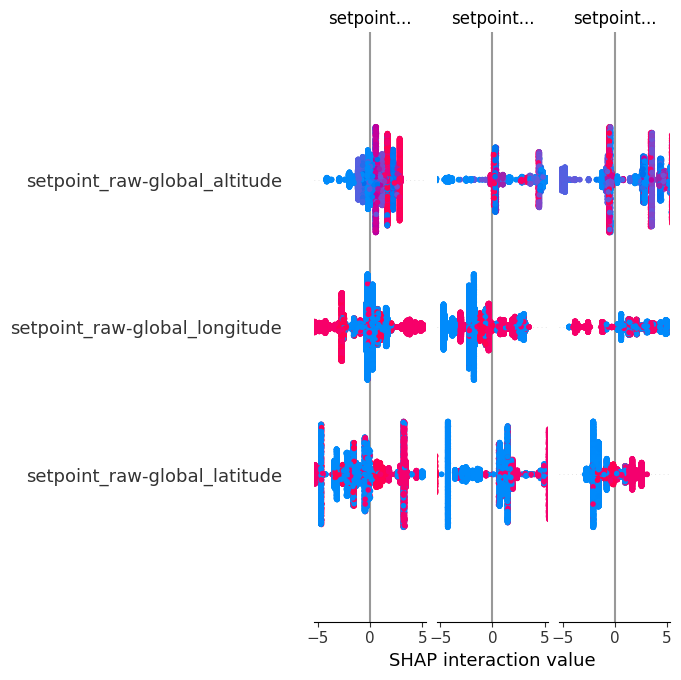

In [47]:
# --- SHAP xgboost
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Plot
shap.summary_plot(shap_values_xgb, X_test, feature_names=feature_cols)



Evaluate Models

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



In [56]:
# Helper function to evaluate classification model
def evaluate_model(model, X_test, y_test, model_name="Model"):
    # Predict class labels
    if "xgb" in model_name.lower():
        y_pred = model.predict(X_test)
    else:  # FNN and CNN
        y_pred_probs = model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"=== {model_name} Evaluation ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    return {"Model": model_name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}


410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
=== FNN Evaluation ===
Accuracy: 0.2241
Precision: 0.0502
Recall: 0.2241
F1 Score: 0.0820

Classification Report:
                   precision    recall  f1-score   support

        Dos-Drone       0.22      1.00      0.37      2938
Malfunction-Drone       0.00      0.00      0.00      2705
     NormalFlight       0.00      0.00      0.00      7470

         accuracy                           0.22     13113
        macro avg       0.07      0.33      0.12     13113
     weighted avg       0.05      0.22      0.08     13113



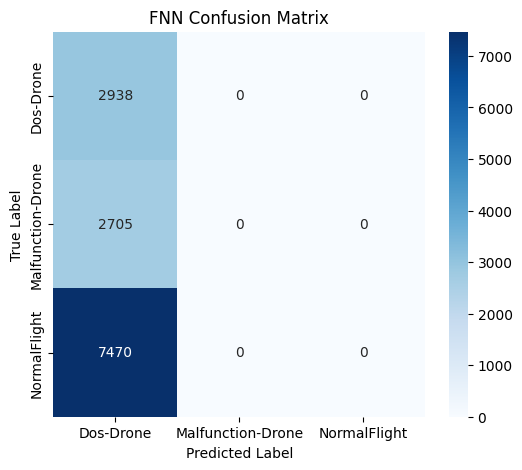

410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
=== 1D-CNN Evaluation ===
Accuracy: 0.2241
Precision: 0.0502
Recall: 0.2241
F1 Score: 0.0820

Classification Report:
                   precision    recall  f1-score   support

        Dos-Drone       0.22      1.00      0.37      2938
Malfunction-Drone       0.00      0.00      0.00      2705
     NormalFlight       0.00      0.00      0.00      7470

         accuracy                           0.22     13113
        macro avg       0.07      0.33      0.12     13113
     weighted avg       0.05      0.22      0.08     13113



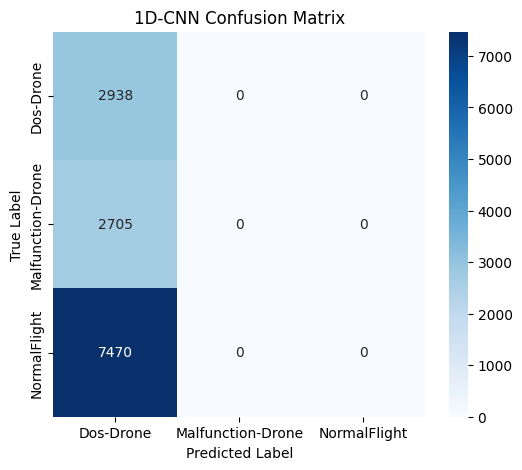

=== XGBoost Evaluation ===
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report:
                   precision    recall  f1-score   support

        Dos-Drone       1.00      1.00      1.00      2938
Malfunction-Drone       1.00      1.00      1.00      2705
     NormalFlight       1.00      1.00      1.00      7470

         accuracy                           1.00     13113
        macro avg       1.00      1.00      1.00     13113
     weighted avg       1.00      1.00      1.00     13113



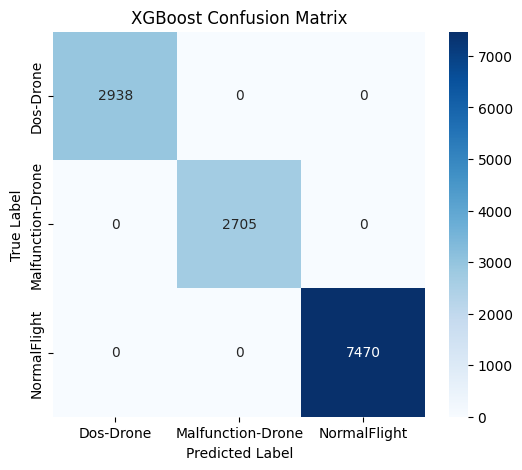

In [58]:
results = []

# FNN
results.append(evaluate_model(fnn_model, X_test, y_test, "FNN"))

# 1D-CNN
results.append(evaluate_model(cnn_model, X_test, y_test, "1D-CNN"))

# XGBoost
results.append(evaluate_model(xgb_model, X_test, y_test, "XGBoost"))


Compare Model Performance

In [59]:
import pandas as pd

# Create performance DataFrame
results_df = pd.DataFrame(results)
results_df.set_index("Model", inplace=True)
results_df


,Accuracy,Precision,Recall,F1
Model,,,,
FNN,0.224052,0.0502,0.224052,0.082022
1D-CNN,0.224052,0.0502,0.224052,0.082022
XGBoost,1.000000,1.0000,1.000000,1.000000


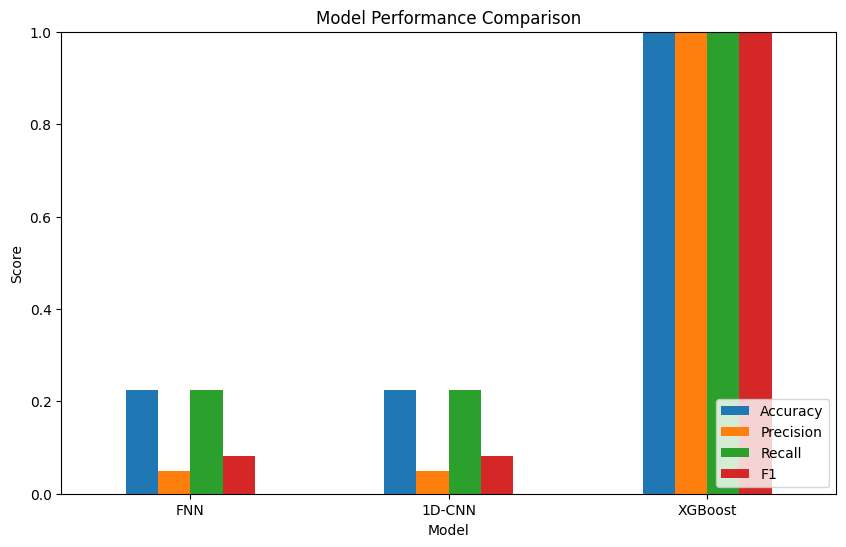

In [60]:
# Plot comparison
results_df.plot(kind='bar', figsize=(10,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()
